In [20]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

import requests
import pandas as pd
import os
from dotenv import load_dotenv
from tqdm import tqdm
import time
import numpy as np

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load API key
load_dotenv()
API_KEY = os.getenv("TMDB_API_KEY")
BASE_URL = "https://api.themoviedb.org/3"

In [21]:
# ---------------------------
# 🔧 TMDB API Functions
# ---------------------------

def get_movies_from_page(page):
    url = f"{BASE_URL}/discover/movie"
    params = {
        "api_key": API_KEY,
        "sort_by": "vote_count.desc",
        "page": page,
        "include_adult": False
    }
    return requests.get(url, params=params).json()


def get_movie_details(movie_id):
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {"api_key": API_KEY}
    return requests.get(url, params=params).json()


def get_movie_credits(movie_id):
    url = f"{BASE_URL}/movie/{movie_id}/credits"
    params = {"api_key": API_KEY}
    return requests.get(url, params=params).json()

In [22]:
# ---------------------------
# 🎥 Scrape Movies from TMDB
# ---------------------------

movies = []
PAGES_TO_SCRAPE = 5  # Increase to 20-30 for more data

for page in tqdm(range(1, PAGES_TO_SCRAPE + 1)):
    page_data = get_movies_from_page(page)
    if "results" not in page_data:
        continue

    for movie in page_data["results"]:
        movie_id = movie["id"]

        # Fetch info
        details = get_movie_details(movie_id)
        credits = get_movie_credits(movie_id)
        time.sleep(0.15)

        cast_count = len(credits.get("cast", []))

        movies.append({
            "id": movie_id,
            "title": details.get("title"),
            "release_year": int(details.get("release_date", "0000")[:4]) if details.get("release_date") else None,
            "budget": details.get("budget"),
            "revenue": details.get("revenue"),
            "runtime": details.get("runtime"),
            "popularity": details.get("popularity"),
            "vote_average": details.get("vote_average"),
            "vote_count": details.get("vote_count"),
            "genre_ids": [g["id"] for g in details.get("genres", [])],
            "production_companies": len(details.get("production_companies", [])),
            "cast_size": cast_count
        })

df = pd.DataFrame(movies)
df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.17s/it]


,id,title,release_year,budget,revenue,runtime,popularity,vote_average,vote_count,genre_ids,production_companies,cast_size
0,157336,Interstellar,2014,165000000,746606706,169,35.1733,8.462,38241,"[12, 18, 878]",3,34
1,27205,Inception,2010,160000000,839030630,148,23.4385,8.370,38222,"[28, 878, 12]",3,52
2,155,The Dark Knight,2008,185000000,1004558444,152,21.5716,8.524,34701,"[18, 28, 80, 53]",4,138
3,24428,The Avengers,2012,220000000,1518815515,143,40.8323,7.852,33972,"[878, 28, 12]",1,113
4,19995,Avatar,2009,237000000,2923706026,162,23.2365,7.593,32813,"[28, 12, 14, 878]",4,65


In [6]:
# ---------------------------
# 🧹 Data Cleaning
# ---------------------------

df = df.dropna(subset=["vote_average", "vote_count", "release_year"])

df["movie_age"] = 2025 - df["release_year"]
df["genre_ids"] = df["genre_ids"].apply(lambda x: x if isinstance(x, list) else [])

all_genres = sorted({g for lst in df["genre_ids"] for g in lst})

for g in all_genres:
    df[f"genre_{g}"] = df["genre_ids"].apply(lambda lst: 1 if g in lst else 0)

df.head()

,id,title,release_year,budget,revenue,runtime,popularity,vote_average,vote_count,genre_ids,...,genre_36,genre_37,genre_53,genre_80,genre_878,genre_9648,genre_10402,genre_10749,genre_10751,genre_10752
0,157336,Interstellar,2014,165000000,746606706,169,35.8722,8.500,38238,"[12, 18, 878]",...,0,0,0,0,1,0,0,0,0,0
1,27205,Inception,2010,160000000,839030630,148,23.4385,8.370,38222,"[28, 878, 12]",...,0,0,0,0,1,0,0,0,0,0
2,155,The Dark Knight,2008,185000000,1004558444,152,21.5716,8.524,34701,"[18, 28, 80, 53]",...,0,0,1,1,0,0,0,0,0,0
3,24428,The Avengers,2012,220000000,1518815515,143,40.5763,7.852,33969,"[878, 28, 12]",...,0,0,0,0,1,0,0,0,0,0
4,19995,Avatar,2009,237000000,2923706026,162,23.2365,7.593,32813,"[28, 12, 14, 878]",...,0,0,0,0,1,0,0,0,0,0


In [7]:
# ---------------------------
# 🏷 Timeless Label
# ---------------------------

df["timeless"] = df.apply(
    lambda row: 1 if (row["vote_average"] >= 8.0 and row["vote_count"] >= 20000) else 0,
    axis=1
)

df["timeless"].value_counts()

timeless
0    374
1     26
Name: count, dtype: int64

In [8]:
# ---------------------------
# 🌎 Global Rename of Genre Columns
# ---------------------------

# Pull TMDB genre name dictionary
genre_url = f"https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}"
genre_map_raw = requests.get(genre_url).json()["genres"]
genre_id_to_name = {g["id"]: g["name"] for g in genre_map_raw}

# Build mapping: genre_28 → Action
genre_col_to_name = {f"genre_{g}": genre_id_to_name[g] for g in all_genres}

# Apply rename globally
df = df.rename(columns=genre_col_to_name)

# Updated genre columns
genre_columns = list(genre_col_to_name.values())

df.head()

,id,title,release_year,budget,revenue,runtime,popularity,vote_average,vote_count,genre_ids,...,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War,timeless
0,157336,Interstellar,2014,165000000,746606706,169,35.8722,8.500,38238,"[12, 18, 878]",...,0,0,0,1,0,0,0,0,0,1
1,27205,Inception,2010,160000000,839030630,148,23.4385,8.370,38222,"[28, 878, 12]",...,0,0,0,1,0,0,0,0,0,1
2,155,The Dark Knight,2008,185000000,1004558444,152,21.5716,8.524,34701,"[18, 28, 80, 53]",...,0,1,1,0,0,0,0,0,0,1
3,24428,The Avengers,2012,220000000,1518815515,143,40.5763,7.852,33969,"[878, 28, 12]",...,0,0,0,1,0,0,0,0,0,0
4,19995,Avatar,2009,237000000,2923706026,162,23.2365,7.593,32813,"[28, 12, 14, 878]",...,0,0,0,1,0,0,0,0,0,0


In [9]:
# ---------------------------
# 📊 Build Feature Matrix
# ---------------------------

feature_columns = [
    "budget", "revenue", "runtime", "popularity",
    "movie_age", "cast_size", "production_companies"
] + genre_columns

X = df[feature_columns].fillna(0)
y = df["timeless"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# ---------------------------
# 🤖 Train Logistic Regression + KNN
# ---------------------------

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_scaled, y_train)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

logreg_preds = logreg.predict(X_test_scaled)
knn_preds = knn.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, logreg_preds))
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

Logistic Regression Accuracy: 0.94
KNN Accuracy: 0.94


In [39]:
# ---------------------------
# ❌ Misclassified Examples
# ---------------------------

misclassified = X_test.copy()
misclassified["actual"] = y_test
misclassified["predicted"] = logreg_preds
misclassified = misclassified[misclassified["actual"] != misclassified["predicted"]]

misclassified_samples = misclassified.head(5)
misclassified_samples

,budget,revenue,runtime,popularity,movie_age,cast_size,production_companies,genre_12,genre_14,genre_16,...,genre_53,genre_80,genre_878,genre_9648,genre_10402,genre_10749,genre_10751,genre_10752,actual,predicted
57,175000000,814641172,105,22.7704,8,83,1,1,0,1,...,0,0,0,0,1,0,1,0,1,0
38,33000000,327311859,127,13.2001,30,59,3,0,0,0,...,1,1,0,1,0,0,0,0,1,0
14,100000000,425368238,165,12.0896,13,136,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,237000000,2923706026,162,23.2365,16,65,4,1,1,0,...,0,0,1,0,0,0,0,0,0,1
9,25000000,28341469,142,25.0494,31,60,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


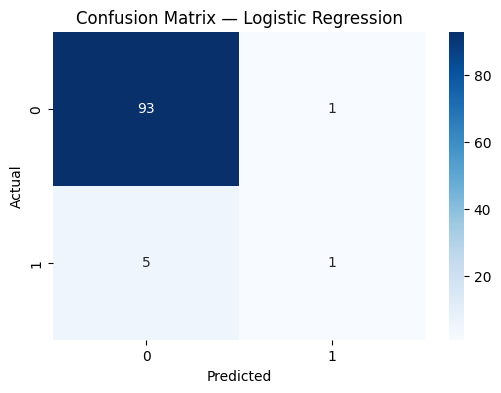


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        94
           1       0.50      0.17      0.25         6

    accuracy                           0.94       100
   macro avg       0.72      0.58      0.61       100
weighted avg       0.92      0.94      0.93       100



In [11]:
# ---------------------------
# 📉 Confusion Matrix
# ---------------------------

cm = confusion_matrix(y_test, logreg_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, logreg_preds))

In [40]:
# ---------------------------
# 🎬 Most Common Timeless Genres
# ---------------------------

timeless_movies = df[df["timeless"] == 1]

genre_columns = [col for col in df.columns if col.startswith("genre_")]
genre_columns = [c for c in genre_columns if c.replace("genre_", "").isdigit()]

for col in genre_columns:
    timeless_movies[col] = timeless_movies[col].astype(int)

genre_counts = timeless_movies[genre_columns].sum().sort_values(ascending=False)
genre_counts

C:\Users\Thanos\AppData\Local\Temp\ipykernel_8812\3182997933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeless_movies[col] = timeless_movies[col].astype(int)
C:\Users\Thanos\AppData\Local\Temp\ipykernel_8812\3182997933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeless_movies[col] = timeless_movies[col].astype(int)
C:\Users\Thanos\AppData\Local\Temp\ipykernel_8812\3182997933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

genre_12       13
genre_18       12
genre_28       10
genre_80        7
genre_53        7
genre_878       7
genre_14        5
genre_35        4
genre_9648      2
genre_10402     1
genre_10749     1
genre_16        1
genre_37        1
genre_10751     1
genre_10752     1
genre_36        0
genre_27        0
dtype: int64

In [12]:
# ---------------------------
# ❌ Misclassified Movies
# ---------------------------

misclassified = X_test.copy()
misclassified["actual"] = y_test
misclassified["predicted"] = logreg_preds
misclassified = misclassified[misclassified["actual"] != misclassified["predicted"]]

misclassified.head(5)

,budget,revenue,runtime,popularity,movie_age,cast_size,production_companies,Adventure,Fantasy,Animation,...,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War,actual,predicted
18,93000000,871368364,179,22.7469,24,117,3,1,1,0,...,0,0,0,0,0,0,0,0,1,0
11,55000000,677387716,142,16.7377,31,175,3,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,237000000,2923706026,162,23.2365,16,65,4,1,1,0,...,0,0,1,0,0,0,0,0,0,1
20,94000000,1118888979,201,19.1680,22,78,3,1,1,0,...,0,0,0,0,0,0,0,0,1,0
38,33000000,327311859,127,13.2001,30,59,3,0,0,0,...,1,1,0,1,0,0,0,0,1,0


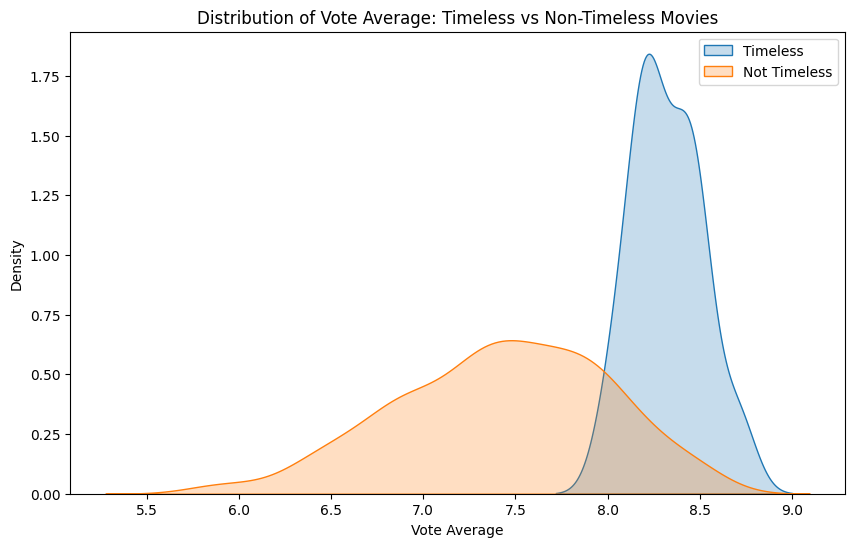

In [13]:
plt.figure(figsize=(10,6))

sns.kdeplot(df[df["timeless"]==1]["vote_average"], label="Timeless", fill=True)
sns.kdeplot(df[df["timeless"]==0]["vote_average"], label="Not Timeless", fill=True)

plt.title("Distribution of Vote Average: Timeless vs Non-Timeless Movies")
plt.xlabel("Vote Average")
plt.ylabel("Density")
plt.legend()
plt.show()

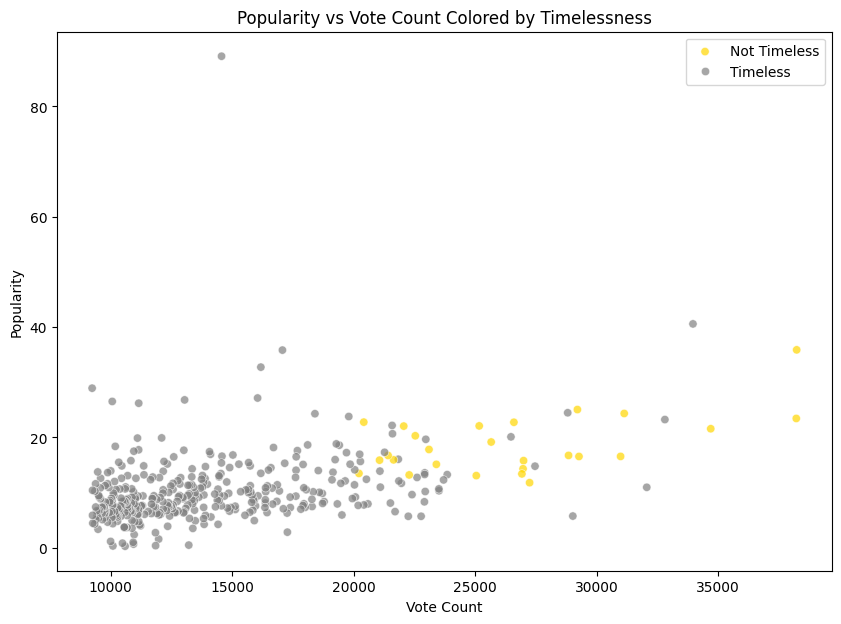

In [14]:
plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df,
    x="vote_count",
    y="popularity",
    hue="timeless",
    palette={0:"gray", 1:"gold"},
    alpha=0.7
)

plt.title("Popularity vs Vote Count Colored by Timelessness")
plt.xlabel("Vote Count")
plt.ylabel("Popularity")
plt.legend(["Not Timeless", "Timeless"])
plt.show()

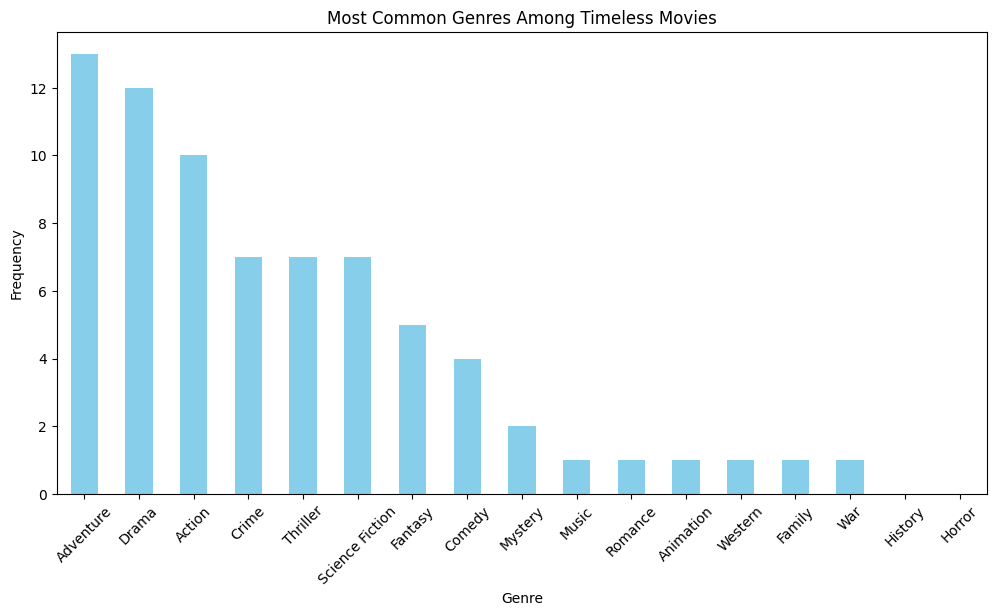

In [16]:
timeless_movies = df[df["timeless"] == 1]

genre_counts_named = timeless_movies[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
genre_counts_named.plot(kind="bar", color="skyblue")
plt.title("Most Common Genres Among Timeless Movies")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

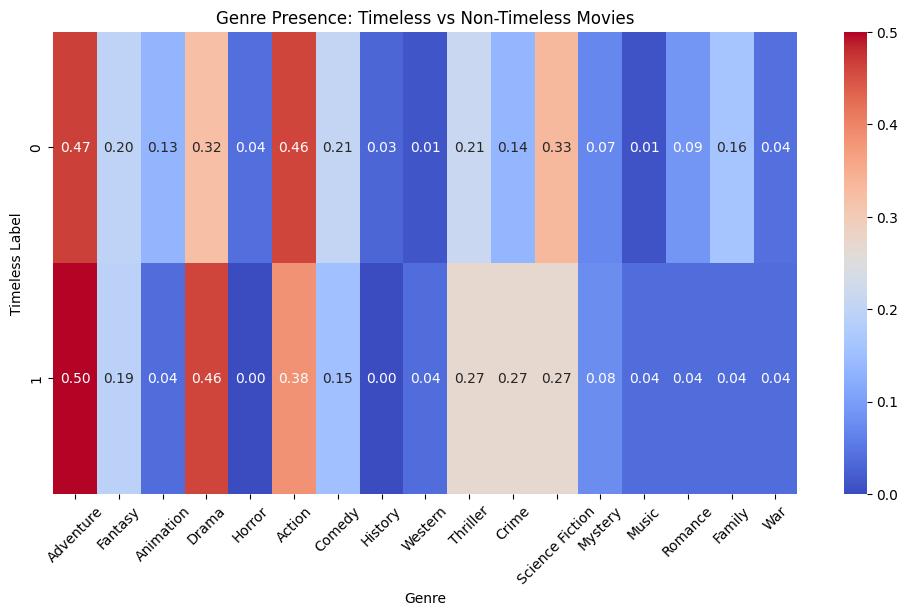

In [17]:
genre_df = df[genre_columns + ["timeless"]]

genre_avg_named = genre_df.groupby("timeless").mean()

plt.figure(figsize=(12,6))
sns.heatmap(genre_avg_named, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Genre Presence: Timeless vs Non-Timeless Movies")
plt.xlabel("Genre")
plt.ylabel("Timeless Label")
plt.xticks(rotation=45)
plt.show()

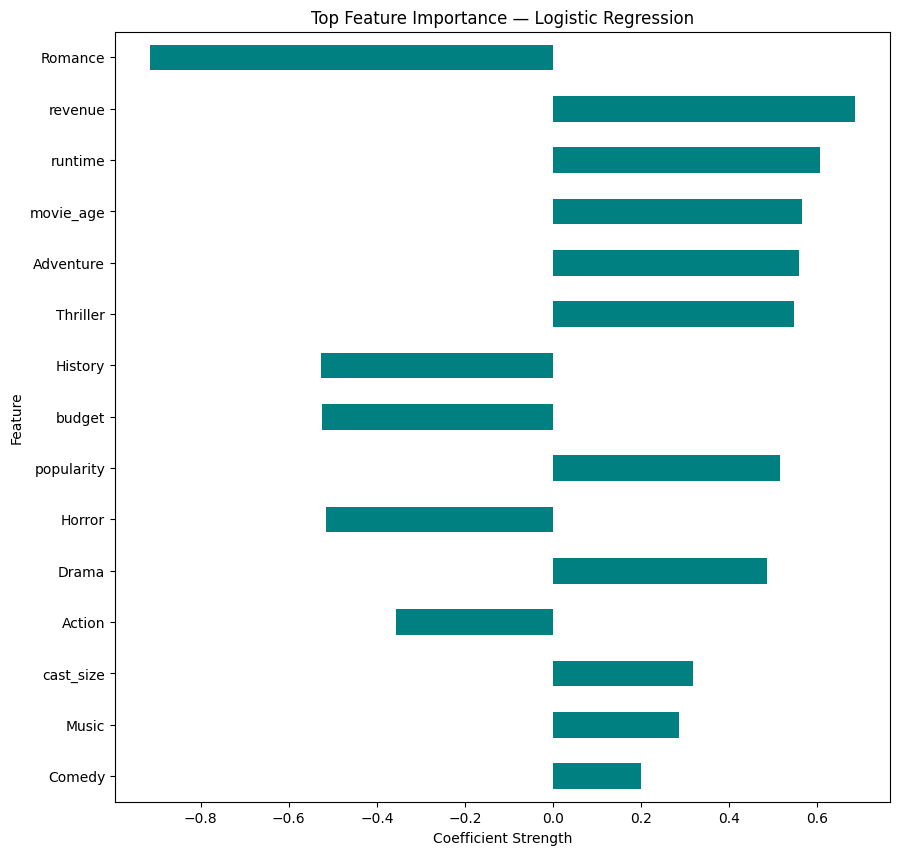

In [18]:
pretty_names = [
    col if col not in genre_col_to_name else genre_col_to_name[col]
    for col in feature_columns
]

coef_series = pd.Series(
    logreg.coef_[0],
    index=pretty_names
).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,10))
coef_series.head(15).plot(kind="barh", color="teal")
plt.title("Top Feature Importance — Logistic Regression")
plt.xlabel("Coefficient Strength")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [19]:
df.to_csv("tmdb_timeless_movies.csv", index=False)
"Saved!"

'Saved!'